In [7]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [8]:
# Load the data
dataset = pickle.load(open('data/ocr_insurance_dataset.pkl', 'rb'))

In [9]:
# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

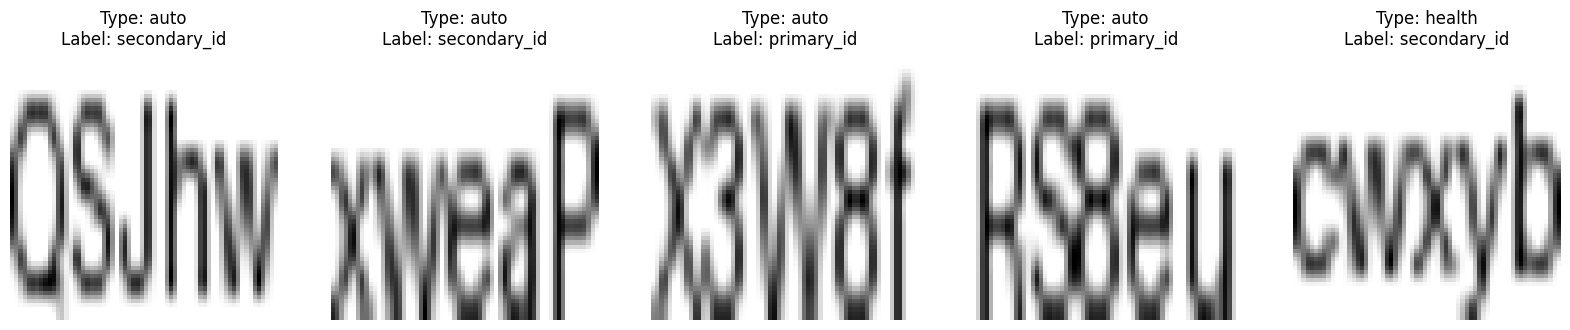

In [10]:
# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [15]:
# Check the dataset attributes
print("Dataset attributes and methods:", dir(dataset))

# Check type and label mappings (if available)
if hasattr(dataset, 'type_mapping'):
    print("Type Mapping:", dataset.type_mapping)

if hasattr(dataset, 'label_mapping'):
    print("Label Mapping:", dataset.label_mapping)

# Check the number of samples
print(f"Number of samples in the dataset: {len(dataset)}")

# Inspect the first sample
sample = dataset[0]
(image, type_data), label = sample
print(f"Shape of the image: {image.shape}")
print(f"Shape of the type data: {type_data.shape}")
print(f"Label: {label}")

Dataset attributes and methods: ['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'data', 'generate_data', 'generate_random_string', 'label_mapping', 'labels', 'num_samples', 'text_to_image', 'text_type_to_vector', 'type_mapping']
Type Mapping: {'home': 0, 'life': 1, 'auto': 2, 'health': 3, 'other': 4}
Label Mapping: {'primary_id': 0, 'secondary_id': 1}
Number of samples in the dataset: 100
Shape of the image: torch.Size([1, 64, 64])
Shape of the type data: torch.Size([5])
Label: 0


Primary ID count: 47
Secondary ID count: 53
home count: 16
life count: 20
auto count: 26
health count: 16
other count: 22


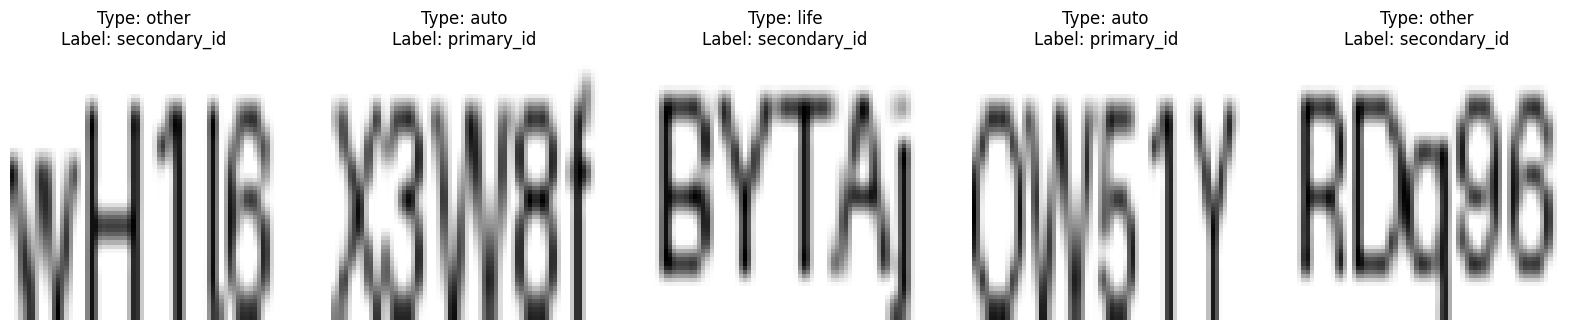

In [16]:
# Check label distribution
labels = [sample[1] for sample in dataset]
print("Primary ID count:", labels.count(0))
print("Secondary ID count:", labels.count(1))

# Check type distribution
types = [sample[0][1].argmax().item() for sample in dataset]
for type_name, type_idx in dataset.type_mapping.items():
    print(f"{type_name} count:", types.count(type_idx))

# Visualize a few samples
show_dataset_images(dataset, num_images=5)

In [11]:
#create the ocr model

class OCRModel(nn.Module):
    def __init__(self, num_insurance_types=5):
        super(OCRModel, self).__init__()

        #Image processing layers
        self.image_layer = nn.Sequential(nn.Con2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),nn.Flatten())

In [12]:
# Write a class to define the model's structure
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)  
        )
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 + 10, 64), 
            nn.ReLU(),
            nn.Linear(64, 2)  
        )
        
    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        x = torch.cat((x_image, x_type), dim=1)  
        return self.classifier(x)

# Load the data in batches
train_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Call the model
model = OCRModel()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train for ten epochs
for epoch in range(10):  
    for (images, types), labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images, types)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.7658251523971558
Epoch 2, Loss: 0.8381439447402954
Epoch 3, Loss: 1.1544742584228516
Epoch 4, Loss: 0.6397875547409058
Epoch 5, Loss: 1.0828150510787964
Epoch 6, Loss: 1.0554530620574951
Epoch 7, Loss: 0.5204309225082397
Epoch 8, Loss: 0.46350064873695374
Epoch 9, Loss: 0.4749738276004791
Epoch 10, Loss: 0.3882630467414856
